In [1]:
import cvxpy as cp
import numpy as np
import osqp
from scipy import sparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import torch
import pandas as pd
from qpth.qp import QPFunction
import time
warnings.filterwarnings('ignore')

In [2]:
ndim = 5
neq = 5
nineq = 5

In [57]:
P = np.random.random((ndim,ndim))
P = P.T@P+(0.0001*np.eye(ndim,ndim))
Pm = P.copy()
P = sparse.csc_matrix(P)
q = cp.Parameter(ndim)
q.value = np.random.random(ndim)
A = np.random.random((neq,ndim))
G = np.random.random((nineq,ndim))
b = np.random.random(neq)
h = G@np.random.random(ndim)
c = np.linalg.norm(np.random.random(ndim),2)
osA = np.vstack([G,A])
osA = sparse.csc_matrix(osA)
l = np.hstack([-np.inf*np.ones(nineq),b])
u = np.hstack([h,b])

In [69]:
x = cp.Variable(ndim)
soc_constraints = [cp.norm(x,2)<= c]

prob = cp.Problem(cp.Minimize(q.T@x),
                  soc_constraints)
prob.solve(requires_grad = True)
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value)
print('gradient is')
prob.backward()
print(q.gradient)

The optimal value is -1.0754149890363587
A solution x is
[-0.41945053 -0.1753434  -0.95889347 -0.09294559 -0.27032009]
gradient is
[-0.37548808 -0.81061491  0.58608191 -0.95749098 -0.64131667]


In [3]:
def osqp_interface(P,q,A,l,u):
    prob = osqp.OSQP()
    prob.setup(P, q, A, l, u,verbose = False)
    t0 = time.time()
    res = prob.solve()
    return res.x,res.y,time.time() - t0

In [71]:
t1 = np.sum(soc_constraints[0].dual_value)
t0 = np.linalg.norm(x.value,2)

In [72]:
pi = x.value
pis = pi[None].T@pi[None]
m1 = soc_constraints[0].dual_value
m0 = np.linalg.norm(x.value,2)
Pm = m1/m0*np.eye(len(x.value)) - m1/(m0**3)*pis
print(Pm)
P = sparse.csc_matrix(Pm)

[[ 0.7606515  -0.05421308 -0.29647289 -0.02873713 -0.08357819]
 [-0.05421308  0.86767542 -0.12393491 -0.01201302 -0.03493829]
 [-0.29647289 -0.12393491  0.21258027 -0.06569511 -0.19106563]
 [-0.02873713 -0.01201302 -0.06569511  0.88397035 -0.01852   ]
 [-0.08357819 -0.03493829 -0.19106563 -0.01852     0.83647518]]


In [73]:
lambs = soc_constraints[0].dual_value # active set
active_set = np.argwhere(lambs>1e-8)
# bG = -c[i].T[active_set,:].squeeze()
bb = np.zeros(len(active_set))
bh = np.zeros(len(active_set))
bq = np.ones(ndim)
osnewA = np.vstack([pi[None]])
osnewA = sparse.csc_matrix(osnewA)
l_new = np.hstack([bb])
u_new = np.hstack([bb])

x_grad, y_grad, time_spent_backward = osqp_interface(P,bq,osnewA,l_new,u_new)
print('OSQP Backward Time spent:',time_spent_backward)

OSQP Backward Time spent: 0.0001900196075439453


In [74]:
x_grad

array([-0.37548995, -0.81061755,  0.58608174, -0.95749388, -0.64131901])

In [75]:
lambs = soc_constraints[0].dual_value
G = pi[None]
br = np.linalg.norm(G,2) - c
KKT_L1 = np.hstack([Pm, G.T])
KKT_L2 = np.hstack([lambs*G, br[None,None]])
KKT = np.vstack([KKT_L1,KKT_L2])
exact_bb =-(np.linalg.inv(KKT)@np.hstack([np.ones(ndim),np.zeros(1)]))[:ndim]
exact_bb

array([-0.37548785, -0.81061481,  0.58608243, -0.95749093, -0.64131652])

In [76]:
report_table = pd.DataFrame({'CVXPY':q.gradient, 'BPQP': x_grad, 'Exact': exact_bb})
report_table

,CVXPY,BPQP,Exact
0,-0.375488,-0.375490,-0.375488
1,-0.810615,-0.810618,-0.810615
2,0.586082,0.586082,0.586082
3,-0.957491,-0.957494,-0.957491
4,-0.641317,-0.641319,-0.641317


In [13]:
def SOCP_instances(ndim):
    q = np.random.random(ndim)
    c = np.linalg.norm(np.random.random(ndim),2)
    return c,q
def SOCP_cvxpy_solver(q,c):
    qq = cp.Parameter(ndim)
    qq.value = q
    x = cp.Variable(ndim)
    x1 = cp.Variable(ndim)
    soc_constraints = [cp.norm(x,2)<= c]
    soc_constraints2 = [cp.norm(x1,2)<= c]
    prob = cp.Problem(cp.Minimize(qq.T@x),
                      soc_constraints)
    prob2 = cp.Problem(cp.Minimize(qq.T@x1),
                      soc_constraints2)
    tt3 = time.time()
    prob2.solve(solver = 'ECOS')
    tt4 = time.time() - tt3
    tt0 = time.time()
    prob.solve(requires_grad = True, solver = 'SCS')
    tt1 = time.time() - tt0
    tt11 = time.time()
    prob.backward()
    tt2 = time.time() - tt11
    return x1.value, qq.gradient, soc_constraints[0].dual_value, tt1, tt2, tt4

def SOCP_BPQP_backward(x,q,c,lambdas):
    if lambdas==0:
        print('No well-defined gradients')
        return 0
    pi = x
    pis = pi[None].T@pi[None]
    m1 = lambdas
    m0 = np.linalg.norm(x,2)
    P = m1/m0*np.eye(len(x)) - m1/(m0**3)*pis
    P = sparse.csc_matrix(P)
    bb = np.zeros(1)
    bh = np.zeros(1)
    bq = np.ones(len(x))
    osnewA = np.vstack([pi[None]])
    osnewA = sparse.csc_matrix(osnewA)
    l_new = np.hstack([bb])
    u_new = np.hstack([bb])
    x_grad, y_grad, time_spent_backward = osqp_interface(P,bq,osnewA,l_new,u_new)
    return x_grad, time_spent_backward
def dict_report(stats, key, value):
    if key in stats.keys():
        stats[key] = np.append(stats[key], value)
    else:
        stats[key] = value
def SOCP_cal_exact_backward(lambs,x,c):
    if lambs==0:
        print('No well-defined gradients')
        return 0
    ndim = len(x)
    pi = x
    pis = pi[None].T@pi[None]
    m1 = lambs
    m0 = np.linalg.norm(pi,2)
    Pm = m1/m0*np.eye(len(pi)) - m1/(m0**3)*pis

    G = pi[None]
    br = np.linalg.norm(G,2) - c
    KKT_L1 = np.hstack([Pm, G.T])
    KKT_L2 = np.hstack([lambs*G, br[None,None]])
    KKT = np.vstack([KKT_L1,KKT_L2])
    t5 = time.time()
    exact_bb =-(np.linalg.inv(KKT)@np.hstack([np.ones(ndim),np.zeros(1)]))[:ndim]
    return exact_bb,time.time()-t5
def cal_L2_accuracy(x_exact,x_approx):
    return np.sqrt(np.sum((x_exact - x_approx)**2))/len(x_exact)
def get_results_table(results_dict):
    d = {}
    missing_methods = []
    for method in results_dict.keys():
        if method in results_dict:
            d[method] = ['{:.1e}({:.1e})'.format(np.nanmean(results_dict[method]),np.nanstd(results_dict[method]))]
        else:
            missing_methods.append(method)
    df = pd.DataFrame.from_dict(d, orient='index')
    df.index.names = ['avg']
    return df

In [14]:
n_list = [10,50,100,500]
cvxpy_stats = {}
stats = {}
time_spent = {}
forward = {}
ecos_f = {}
exact_back = {}
exact_acc = {}
iters = 100
for i in tqdm(range(iters)):
    for ndim in n_list:
        c,q = SOCP_instances(ndim) # neq = nineq
        x_cp_value, x_cp_grad, lambdas,time_spent_forward,time_spent_backward, time_ecos_spent = SOCP_cvxpy_solver(q,c) # cvxpy Forward and Backward
        
        x_grad, bpqp_backward_timespent = SOCP_BPQP_backward(x_cp_value,q,c,lambdas)
        exact_grad, exact_timespent = SOCP_cal_exact_backward(lambdas,x_cp_value,c)

        acc_backward = cal_L2_accuracy(x_cp_grad,exact_grad)
        acc_cvxpy = cal_L2_accuracy(exact_grad,x_grad)
        dif = cal_L2_accuracy(x_cp_grad,x_grad)

        dict_report(cvxpy_stats, f'{ndim}', time_spent_backward)
        dict_report(ecos_f, f'{ndim}', time_ecos_spent)
        dict_report(forward, f'{ndim}', time_spent_forward)
        dict_report(stats, f'{ndim}', bpqp_backward_timespent)
        dict_report(exact_back, f'{ndim}', exact_timespent)
        dict_report(exact_acc, f'{ndim}', acc_cvxpy)

        dict_report(time_spent, f'{ndim}', acc_backward)

100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


In [18]:
df_cp = pd.DataFrame(cvxpy_stats).to_csv('cvxpy_backward_time.csv')
df_bp = pd.DataFrame(stats).to_csv('bpqp_backward_time.csv')
df_time = pd.DataFrame(time_spent).to_csv('cp_acc.csv')
df_ecos = pd.DataFrame(ecos_f).to_csv('ecos_forward.csv')
df_forward = pd.DataFrame(forward).to_csv('cvxpy_forward_time.csv')
df_exact = pd.DataFrame(exact_back).to_csv('exact_back_time.csv')
df_acc = pd.DataFrame(exact_acc).to_csv('bpqp_acc.csv')

In [16]:
df_acc 

In [11]:
df_time

,10,50,100,500
0,1.486331e-08,3.226243e-09,5.833086e-09,3.585319e-09
1,1.453105e-09,8.331990e-09,5.300739e-09,2.190836e-09
2,3.555153e-07,1.227928e-08,2.012172e-09,4.111047e-09
3,1.450719e-06,4.734354e-08,7.114831e-09,2.286451e-09
4,1.387568e-08,2.875038e-09,5.279939e-09,3.916994e-09
...,...,...,...,...
95,4.879916e-10,6.190198e-09,2.403059e-10,4.016243e-09
96,8.022883e-08,5.546287e-07,3.935753e-09,3.464820e-09
97,2.704484e-06,3.617143e-08,6.599232e-09,2.958359e-09
98,8.861937e-07,2.334747e-08,1.422604e-09,3.259165e-09


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

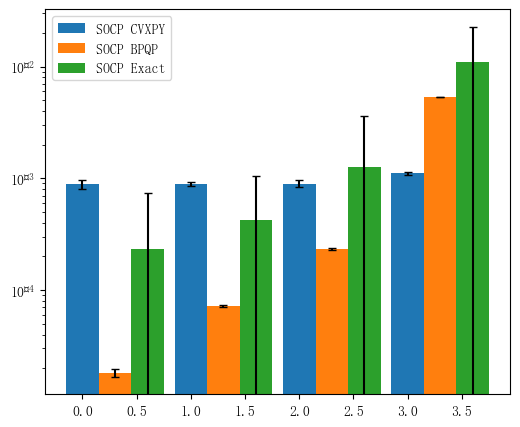

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

barWidth = 0.3
bars1 = df_cp.mean(axis=0)#+df_forward.mean(axis=0)
bars2 = df_bp.mean(axis=0)#+df_ecos.mean(axis=0)
bars3 = df_exact.mean(axis=0)#+df_ecos.mean(axis=0)*0.5++df_forward.mean(axis=0)*0.5
 
yer1 = df_cp.std(axis=0)
yer2 = df_bp.std(axis=0)
yer3 = df_exact.std(axis=0)
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bars1, width = barWidth, 
        yerr=yer1, capsize=3, label='CVXPY')
plt.bar(r2, bars2, width = barWidth, 
        yerr=yer2, capsize=3, label='BPQP')
plt.bar(r3, bars3, width = barWidth, 
        yerr=yer3, capsize=3, label='Exact')
ax.set_yscale('log')
plt.legend(['SOCP CVXPY', 'SOCP BPQP', 'SOCP Exact'])
plt.show()

In [185]:
df = get_results_table(stats)
df

,0
avg,
10,1.8e-04(1.1e-03)
50,2.5e-04(1.1e-03)
100,4.7e-04(1.5e-03)
500,5.8e-03(4.2e-03)


In [131]:
stats['Time CVXPY Backward ndim:10']

array([0.01153159, 0.00552511, 0.00549984, 0.00513721, 0.00535083,
       0.00511384, 0.00563025, 0.00551391, 0.0052619 , 0.00534678,
       0.00504327, 0.00553393, 0.00533605, 0.00539398, 0.00512409,
       0.0054462 , 0.00489807, 0.00525594, 0.00529909, 0.00545478])

In [ ]:
plt.bar(stats['Time CVXPY Backward ndim:10'], y1, tick_label=['a', 'b', 'c', 'd', 'e'], width=bar_width)
plt.bar(x, y1, bottom=y1, width=bar_width, yerr=error)
plt.show()

In [90]:
c,q = SOCP_instances(ndim,neq,nineq) # neq = nineq
x_cp_value, x_cp_grad, lambdas,time_spent_forward,time_spent_backward = SOCP_cvxpy_solver(q,c) # cvxpy Forward and Backward
x_grad, bpqp_backward_timespent = SOCP_BPQP_backward(x_cp_value,q,c,lambdas)


In [91]:
pd.DataFrame({'CVXPY':x_cp_grad,'BPQP':x_grad})

,CVXPY,BPQP
0,0.092684,0.092686
1,-0.214655,-0.214655
2,0.047027,0.047028
3,-0.297333,-0.297334
4,0.181616,0.181618
